# Training Pipeline
This notebook walks through the entire process of loading, cleaning, and encoding TED Talks, followed by the training, testing, and saving of a model.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import random
import json
import re

## Data loading and cleaning

In [2]:
NEXT = 'NNNNN'
APPLAUSE = 'AAAAA'
LAUGHTER = 'LLLLL'
reactions = ["😐", "👏", "😂"]

In [3]:
df = pd.read_csv('ted_talks_en.csv')

In [4]:
transcripts = df[[(not x) for x in df['transcript'].isnull()]]['transcript']
transcripts

0       Thank you so much, Chris. And it's truly a gre...
1       About 10 years ago, I took on the task to teac...
2       (Music: "The Sound of Silence," Simon & Garfun...
3       If you're here today — and I'm very happy that...
4       Good morning. How are you? (Audience) Good. It...
                              ...                        
4000    "I'm 14, and I want to go home." "My name is B...
4001    In 1905, psychologists Alfred Binet and Théodo...
4002    Picture yourself driving down the road tomorro...
4003    In early 1828, Sojourner Truth approached the ...
4004    Can you guess what you’re looking at? Is it a ...
Name: transcript, Length: 4005, dtype: object

In [5]:
def sentencize(text):
    # Audience interactions
    transcript = re.sub(r"\((.*?)\)", r"\n{\1}.\n", text)
    # Replace funky punctuation
    transcript = re.sub(r" \.\.\.", ",", transcript)
    transcript = re.sub(r" —", ",", transcript)
    transcript = re.sub(r":", ",", transcript)
    transcript = re.sub(r";", ",", transcript)
    transcript = re.sub(r"!", ".", transcript)
    sent_tokenize(transcript)
    # Go through each line
    lines = transcript.splitlines()
    lines = [x.strip() for x in lines]
    lines = [x for x in lines if x != '']
    sentences = []
    for line in lines:
        if line == '{Laughter}.':
            sentences.append('LLLLL')
        elif line in ['{Applause}.', '{Cheers}.', '{Cheers and applause}.', '{Applause and cheers}.', '{Applause, cheers}.', '{Audience cheers}.', '{Cheering}.']:
            sentences.append('AAAAA')
        elif len(line) >= 2 and line[0] != '{' and line[-2:] != '}.':
            sentences += sent_tokenize(line)
    return sentences

def full_sentencize(texts):
    sentences = []
    for i in range(len(texts)):
        sentences += ['NNNNN']
        sentences += sentencize(texts[i])
    return sentences

In [6]:
# Clean and split sentences
sentences = full_sentencize(transcripts)

## Text encoding

In [7]:
# Only consider the top 20k words
VOCAB_SIZE = 20000  
# Only consider the first 200 words of each sample
MAXLEN = 200

In [237]:
dont_count = ["``", "''"]

def get_encodings(text, vocab_size):
    ''' Get word -> index and index -> word based on token frequency '''
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in dont_count]
    word_freqs = dict(collections.Counter(tokens))
    word_freqs_list = [(k, v) for k, v in word_freqs.items()]
    sorted_frequencies = sorted(word_freqs_list, key=lambda x: -x[1])
    abridged = sorted_frequencies[:vocab_size]
    words = [x[0] for x in abridged]
    word_to_index = {}
    for i, word in enumerate(words):
        word_to_index[word] = (i + 1)
    return word_to_index

def encode_sentence(text, word_to_index):
    ''' Encode a sentence '''
    tokenized = word_tokenize(text.lower())
    return [(word_to_index[word] if (word in word_to_index) else 0) for word in tokenized]

In [238]:
# Don't include the NEXT token as a token
sentences_no_next = [s for s in sentences if s != NEXT]

In [ ]:
# Get encodings
word_to_index = get_encodings(' '.join(sentences_no_next), vocab_size=VOCAB_SIZE)

In [240]:
word_to_index

{',': 1,
 '.': 2,
 'the': 3,
 'and': 4,
 'to': 5,
 'of': 6,
 'a': 7,
 'that': 8,
 'i': 9,
 'in': 10,
 'it': 11,
 'we': 12,
 'you': 13,
 'is': 14,
 "'s": 15,
 'this': 16,
 'so': 17,
 'they': 18,
 'for': 19,
 'was': 20,
 'are': 21,
 'but': 22,
 'have': 23,
 'with': 24,
 'on': 25,
 'what': 26,
 'do': 27,
 '?': 28,
 "n't": 29,
 'can': 30,
 'be': 31,
 'as': 32,
 'about': 33,
 'not': 34,
 'there': 35,
 'my': 36,
 'at': 37,
 'all': 38,
 'people': 39,
 'one': 40,
 'like': 41,
 'our': 42,
 "'re": 43,
 'from': 44,
 'if': 45,
 'or': 46,
 'an': 47,
 'when': 48,
 'just': 49,
 'these': 50,
 'now': 51,
 'he': 52,
 'me': 53,
 'because': 54,
 'by': 55,
 'how': 56,
 'more': 57,
 'them': 58,
 'their': 59,
 'out': 60,
 'your': 61,
 'had': 62,
 'up': 63,
 'know': 64,
 'were': 65,
 'who': 66,
 'would': 67,
 'very': 68,
 'going': 69,
 'us': 70,
 'think': 71,
 'see': 72,
 'which': 73,
 'get': 74,
 'really': 75,
 'time': 76,
 'here': 77,
 'world': 78,
 'lllll': 79,
 'some': 80,
 'then': 81,
 "'ve": 82,
 'could

Now we create our X and y data with a max-3-sentence sliding window to predict one of three reactions.

In [17]:
special = [APPLAUSE, LAUGHTER]

def create_dataset(sentences, num_sentences=3):
    ''' Create X and y data using sliding window approach '''
    X = []
    y = []
    for i in range(len(sentences)):
        # Don't end a sentence with a special
        if sentences[i] in (special + [NEXT]):
            continue
        # Encode sentence
        current_batch = encode_sentence(sentences[i], word_to_index)
        retrace_index = 0
        sentence_count = 1
        # Pre-append sentences to the list until we hit our desired no. context sentences
        while sentence_count < num_sentences:
            retrace_index += 1
            index = i - retrace_index
            # If we hit the beginning of the speech, give up
            if index < 0 or sentences[index] == NEXT:
                break
            # Skip specials
            elif sentences[index] in special:
                continue
            current_batch = encode_sentence(sentences[index], word_to_index) + current_batch
            sentence_count += 1
        X.append(current_batch)
        # y is the reaction following this sentence
        if i < len(sentences) - 1 and sentences[i + 1] in special:
            y.append(special.index(sentences[i + 1]) + 1)
        # If no reaction, reaction is 0
        else:
            y.append(0)
    return X, np.array(y)

In [300]:
X, y = create_dataset(sentences)

<AxesSubplot:ylabel='Count'>

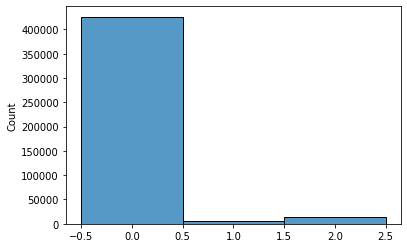

In [301]:
# Check the distribution of reactions
sns.histplot(y, discrete=True)

This is highly imbalanced, so we'll synthetically undersample the "no reaction" X data.

In [20]:
def downsample_zeros(X, y, rate=(1/8)):
    ''' Downsample class 0 with given rate '''
    X_keep = []
    y_keep = []
    for i in range(len(X)):
        if not (y[i] == 0 and random.random() > rate):
            X_keep.append(X[i])
            y_keep.append(y[i])
    return X_keep, np.array(y_keep)

In [332]:
X, y = downsample_zeros(X, y, rate=(3/4))

<AxesSubplot:ylabel='Count'>

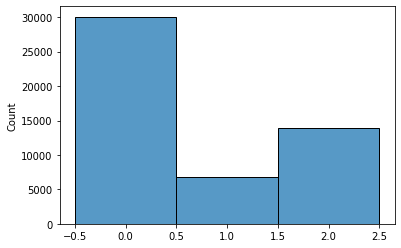

In [333]:
sns.histplot(y, discrete=True)

## Training and testing
First we define the Transformer model.

In [245]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [246]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [267]:
def defineTransformer(embed_dim=128, num_heads=2, ff_dim=64):
    ''' Define and return Transformer with given parameters '''
    inputs = layers.Input(shape=(MAXLEN,))
    embedding_layer = TokenAndPositionEmbedding(MAXLEN, VOCAB_SIZE + 1, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Lambda(lambda x: x[:,-1])(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [370]:
model = defineTransformer()
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 128)          2585728   
_________________________________________________________________
transformer_block_7 (Transfo (None, 200, 128)          149056    
_________________________________________________________________
global_average_pooling1d_6 ( (None, 128)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 20)                2580      
_________________________________________________________________
dropout_31 (Dropout)         (None, 20)                0   

### Data preparation

In [367]:
# Split data into train and testing data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [368]:
# Pad sequences to a constant length
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAXLEN)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=MAXLEN)

### Training and testing

In [371]:
N_EPOCHS = 4
# Weights for minority class enforcing
weights = {0: 1, 1: 1, 2: 1}

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train, y_train, batch_size=32, epochs=N_EPOCHS, 
    validation_data=(X_val, y_val), 
    class_weight=weights,
    # Early stopping
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)]
)

Epoch 1/4
1426/1426 [==============================] - 430s 301ms/step - loss: 0.8637 - accuracy: 0.6261 - val_loss: 0.6563 - val_accuracy: 0.7291
Epoch 2/4
1426/1426 [==============================] - 419s 294ms/step - loss: 0.6189 - accuracy: 0.7387 - val_loss: 0.6563 - val_accuracy: 0.7203
Epoch 3/4
1426/1426 [==============================] - 409s 287ms/step - loss: 0.4990 - accuracy: 0.7929 - val_loss: 0.7364 - val_accuracy: 0.6924
Epoch 4/4
1426/1426 [==============================] - 427s 299ms/step - loss: 0.4178 - accuracy: 0.8205 - val_loss: 0.8095 - val_accuracy: 0.6990


In [372]:
def plot_loss_history(history):
    ''' Plot training and validation loss over epochs '''
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0, len(loss_train))
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

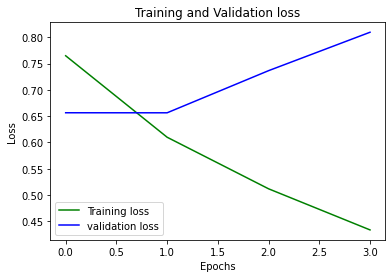

In [373]:
plot_loss_history(history)

In [374]:
# Make predictions
predictions = model.predict(X_val)
y_pred = np.argmax(predictions, axis=-1)

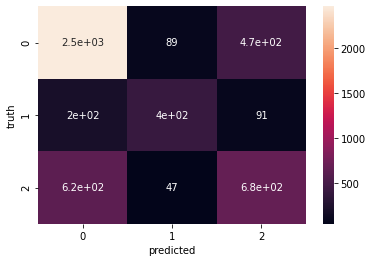

In [375]:
# Check confusion matrix
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)
plt.xlabel("predicted")
plt.ylabel("truth")
plt.show()

### Qualitative test

In [389]:
toy_text = [
    "NNNNN",
    "Hello everyone, and welcome to my TED Talk.",
    "These past few weeks, I've been working on a project that I'm very excited to show you.",
    "This program will listen to you as you speak, and determine whether what you just said was funny, impressive, or neither.",
    "Then, it laughs or applauds accordingly, ensuring your genius never goes unnoticed.",
    "With this application, people from around the world will finally be able to deliver a TED Talk from the comfort of their own home, and receive the attention they deserve.",
    "",
    "Thank you very much."
]

In [390]:
# Create windows and pad
toy_X, _ = create_dataset(toy_text)
toy_X = keras.preprocessing.sequence.pad_sequences(toy_X, maxlen=MAXLEN)

In [391]:
# Make predictions
toy_pred = model.predict(toy_X)
toy_pred = np.argmax(toy_pred, axis=-1)

In [392]:
toy_pred

array([1, 0, 2, 0, 2, 1, 1, 1])

In [41]:
# Print reactions
for i, sent in enumerate([s for s in toy_sentences if s != NEXT]):
    print(sent)
    print(f">> REACTION: {reactions[toy_pred[i]]}")

NameError: name 'toy_sentences' is not defined

### Model persistence

In [363]:
SAVE_INDEX = 420

In [393]:
# Save model
model.save(f'transformer_{SAVE_INDEX}')

INFO:tensorflow:Assets written to: transformer_420/assets


INFO:tensorflow:Assets written to: transformer_420/assets


In [394]:
# Save encodings
with open(f'word_to_index_{SAVE_INDEX}.json', 'w') as f:
    json.dump(word_to_index, f)